## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from oqd_compiler_infrastructure import Post, PrettyPrint
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    Phonon,
    Pulse,
    SequentialProtocol,
    System,
    Transition,
)

from oqd_trical.backend import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 10,
    label="q1",
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
    label="e0",
)
estate2 = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=1,
    energy=2 * np.pi * 110,
    label="e1",
)

transitions = [
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
    Transition(
        level1=downstate, level2=estate2, einsteinA=1, multipole="E1", label="q0->e1"
    ),
    Transition(
        level1=upstate, level2=estate, einsteinA=1, multipole="E1", label="q1->e0"
    ),
    Transition(
        level1=upstate, level2=estate2, einsteinA=1, multipole="E1", label="q1->e1"
    ),
]


Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

COM_x = Phonon(energy=0.1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 1,
    detuning=0,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[1],
    rabi=2 * np.pi * 1,
    detuning=0,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

protocol = SequentialProtocol(
    sequence=[
        Pulse(beam=beam, duration=5),
        Pulse(beam=beam2, duration=5),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("6_example_sequential.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("6_example_sequential.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
backend = QutipBackend()

fock_cutoff = 10
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

printer = Post(PrettyPrint())

print(printer(experiment))

QutipExperiment
  - base: NoneType(None)
  - sequence: list
    - 0: QutipGate
      - hamiltonian: QobjEvo(QobjEvo: dims = [[4, 10], [4, 10]], shape = (40, 40), type = oper, superrep = None, isconstant = False, num_elements = 12)
      - duration: float(5.0)
    - 1: QutipGate
      - hamiltonian: QobjEvo(QobjEvo: dims = [[4, 10], [4, 10]], shape = (40, 40), type = oper, superrep = None, isconstant = False, num_elements = 12)
      - duration: float(5.0)


### Results


In [7]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

10.0%. Run time:   0.27s. Est. time left: 00:00:00:02


20.0%. Run time:   0.55s. Est. time left: 00:00:00:02


30.1%. Run time:   0.83s. Est. time left: 00:00:00:01


40.1%. Run time:   1.10s. Est. time left: 00:00:00:01


50.1%. Run time:   1.38s. Est. time left: 00:00:00:01


60.1%. Run time:   1.65s. Est. time left: 00:00:00:01


70.1%. Run time:   1.93s. Est. time left: 00:00:00:00


80.2%. Run time:   2.20s. Est. time left: 00:00:00:00


90.2%. Run time:   2.47s. Est. time left: 00:00:00:00


100.0%. Run time:   2.74s. Est. time left: 00:00:00:00


Total run time:   2.75s


10.0%. Run time:   0.26s. Est. time left: 00:00:00:02


20.0%. Run time:   0.52s. Est. time left: 00:00:00:02


30.1%. Run time:   0.78s. Est. time left: 00:00:00:01


40.1%. Run time:   1.05s. Est. time left: 00:00:00:01


50.1%. Run time:   1.31s. Est. time left: 00:00:00:01


60.1%. Run time:   1.58s. Est. time left: 00:00:00:01


70.1%. Run time:   1.85s. Est. time left: 00:00:00:00


80.2%. Run time:   2.11s. Est. time left: 00:00:00:00


90.2%. Run time:   2.38s. Est. time left: 00:00:00:00


100.0%. Run time:   2.64s. Est. time left: 00:00:00:00


Total run time:   2.64s


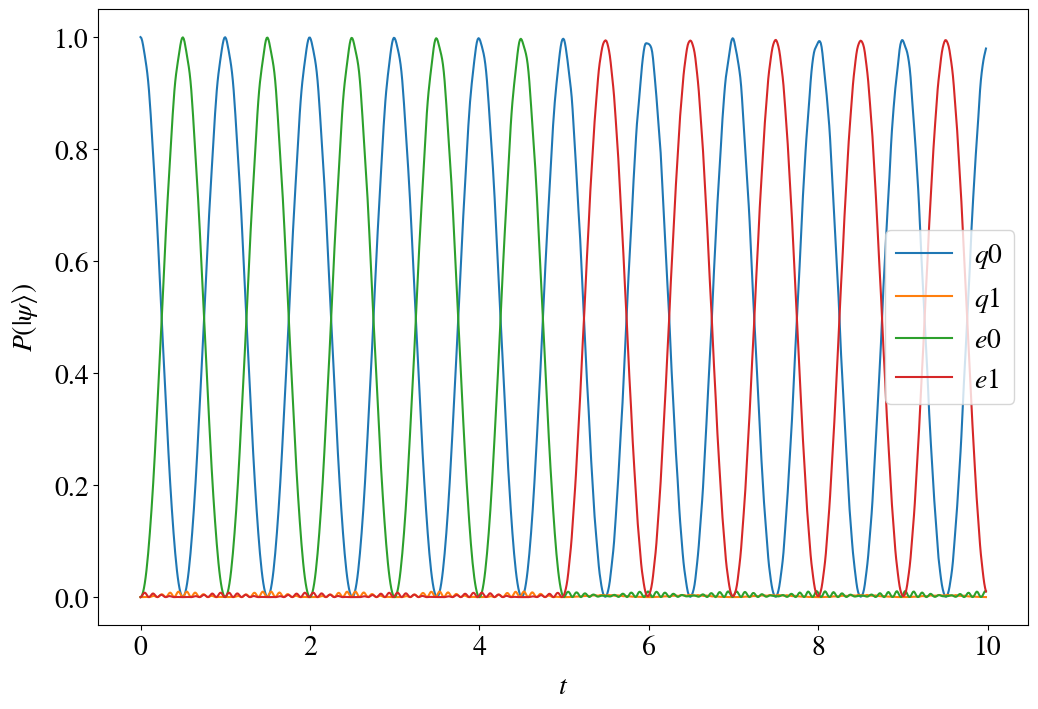

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:4] for s in result["states"][k]],
    label=[rf"${level.label}$" for level in Yb171.levels],
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()